# CardioLife. Sprint 3  <img src="/Users/vioreliamagari/Desktop/capstone_may2024/images/logoCardioLife.png" alt="Image" width="150" style="float: right"/>
## Choosing the best model and make a Streamlit app

In the last sprint we did data pre-processing and baseline modelling: 
* mapped the columns: `gender`, `smoke`, `alco`, `active` into binary columns
* did OneHotEncoder for the columns: `cholesterol` and `gluc`
* did GridSearch for the best parameters of three types of models: Logistic Regression, Decision Tree and K-nearest neighbors
* did Models Evaluaton: classification report, confusion matrix, ROC curve
* from those three models, the best one was Decisin Tree, with a Recall of 0.72

In this Sprint we will do:
## Table of Contents

##### 1. [Random Forest Tree Classifier](#Advanced_modelling)
##### 2. [Model Evaluation](#model_evaluation)
##### 3. [Best Model](#best_model)
##### 4. [Model optimization](#model_optimization)
##### 5. [Preparation for Streamlit app](#preparation)
##### 6. [Conclusion](#Conclusion)

#### **<a id='Advanced_modelling'> 1. Random Forest Tree Classifier </a>**

First of all let's import all the libraries that we will need:

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

Now, let's read our dataset that we saved previously: 

In [117]:
cardio_df = pd.read_csv('/Users/vioreliamagari/Desktop/capstone_may2024/data/cardio_model.csv')
cardio_df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,18393,1,168,62.0,110,80,0,0,1,0,21.967120,1.0,0.0,0.0,1.0,0.0,0.0
1,20228,0,156,85.0,140,90,0,0,1,1,34.927679,0.0,0.0,1.0,1.0,0.0,0.0
2,18857,0,165,64.0,130,70,0,0,0,1,23.507805,0.0,0.0,1.0,1.0,0.0,0.0
3,17623,1,169,82.0,150,100,0,0,1,1,28.710479,1.0,0.0,0.0,1.0,0.0,0.0
4,17474,0,156,56.0,100,60,0,0,0,0,23.011177,1.0,0.0,0.0,1.0,0.0,0.0


As we did in Sprint 2, we need to:
* Set up our data
* Split the training and test data
* Grid search for the best hyperparameters
* Build the models with the best hyperparameters


**Data setup** 

In [118]:
#define X and Y
X = cardio_df.drop(['cardio'], axis=1)
y = cardio_df['cardio'] 

**Split train and test data**

Now, we will split our data into two parts:
1) *Train data* - the biggest part (80%), it will be the data that our models will be trained with
2) *Test data* - the smallest part (20%), it will be the data with the help of which we will test and evaluate our models

In [119]:
# import train test split
from sklearn.model_selection import train_test_split

#split the train (80%) and test data (20%), use stratify and random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

Now we can proceeed to do modelling. 

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

We can GridSearch through Random Forest Classifier for the best parameters: number of estimators and maximum depth. 

In [19]:
#define the parameters that the GridSearch will search through
param_grid = [
    {
        'n_estimators': [10, 50, 100, 150, 200, 300, 400, 500], 
        'max_depth': [10,20,30,40,50]
    }
]
#use GridSearch 
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
fittedgrid = grid.fit(X_train[::2], y_train[::2])

In [20]:
# Best hyperparameters
best_params = fittedgrid.best_params_
#best score
best_score = fittedgrid.best_score_
#print
print(f'Best parameters are: {best_params}')
print(f'Best score is: {best_score}')

Best parameters are: {'max_depth': 10, 'n_estimators': 100}
Best score is: 0.7361853313068965


We can see that the best parameters are:
* maximum depth - 10
* number of estimators - 100

The best score of the GridSearch is 0.74, that is a good score. 

Now let's build the Random Forest Classifier model with those parameters:

In [212]:
# instantiate the Decision Tree Classifier model with the best hyperparameters
best_ran_tree = RandomForestClassifier(max_depth = 10, 
                                       n_estimators= 100
                                       )  
best_ran_tree.fit(X_train, y_train)
#Print the train and test score
print(f'Train Score: {best_ran_tree.score(X_train, y_train)}')
print(f'Test Score: {best_ran_tree.score(X_test, y_test)}')

Train Score: 0.756140923769094
Test Score: 0.733763877802772


Therefore, we got a Train Score of **0.76** (the highest from all models) and a Test score of **0.73**. Now let's proceed to the next step.

#### **<a id='model_evaluation'> 2. Model evaluation </a>**

*Classification report*

In [213]:
from sklearn.metrics import classification_report
y_pred_rf = best_ran_tree.predict(X_test)
#make classification report
report_log = classification_report(y_test, y_pred_rf)
print(report_log)

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6961
           1       0.75      0.68      0.72      6820

    accuracy                           0.73     13781
   macro avg       0.74      0.73      0.73     13781
weighted avg       0.74      0.73      0.73     13781



We see that the ratio between the correctly predicted patients who have a CVD to the total of patients who have a CVD, or the *precision*, is **0.75**. The ratio of correctly predicted patients who have a CVD to all patients, or the *recall*, is **0.68**. The mean of precision and recall, or *F1-score*, is **0.72**, and the *accuracy* is **0.73**. 

We can tell that Random Forest Classification is a good model, but we need to make sure that we have less false negatives, and that the recall is higher. 

Now, let's look at the *Confusion Matrix* of the Random Forest Classifier: 

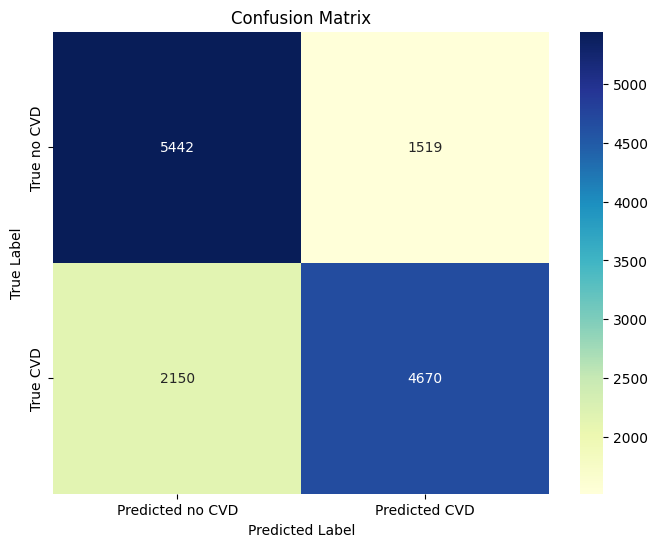

In [214]:
from sklearn.metrics import confusion_matrix

#Get predictions
y_pred_rf = best_ran_tree.predict(X_test)

# Generate confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['Predicted no CVD', 'Predicted CVD'], 
            yticklabels=['True no CVD', 'True CVD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Therefore, we observe that there is:
We can tell that there is:
* 5442 patients that were correctly predicted to be without a CVD (true negative)
* 2150 patients that were incorrectly predicted to be without CVD (false negative), in reality they have this diagnose
* 1519 patients that were incorrectly predicted to be with a CVD (false positive), in reality they were healthy
* 4670 patients that were correctly predicted to be with a CVD(true positive)

Now let's look at the ROC curve and AUC score:  

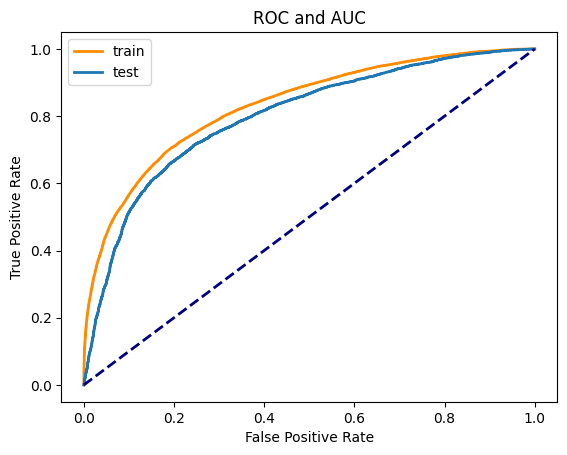

Test AUC score: 0.7984081819909079
Train AUC score: 0.8320073982354556


In [215]:
from sklearn.metrics import roc_curve, roc_auc_score

#Get the probability for each point in the test set.
y_proba_test_rf = best_ran_tree.predict_proba(X_test)[:,1]

#Get the probability for each point in the train set.
y_proba_train_rf = best_ran_tree.predict_proba(X_train)[:,1]

# Compute ROC curve and AUC for for the one class
roc_auc_test = roc_auc_score(y_test, y_proba_test_rf)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_proba_test_rf)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_train_rf)
roc_auc_train = roc_auc_score(y_train, y_proba_train_rf)

# Plot the ROC curve.
plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label='train')
plt.plot(fprs_test, tprs_test, lw=2, label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print(f"Test AUC score: {roc_auc_test}")
print(f"Train AUC score: {roc_auc_train}")

We can observe that the ROC curve for the train data is slightly above the ROC curve of the test data. Also, both curves are close to the top-left corner, suggesting a high accuracy. 

The test AUC score is 0.80 and the train AUC score is 0.83. They are quite similar, indicating that the model generalizes well from training to test data without significant overfitting or underfitting. We can tell that the Random Forest model has a strong predictive performance. 

#### **<a id='best_model'> 3. Choosing the best model </a>**

Based on the results from the Sprint 2, the best model was Decision Tree Classifier. Therefore, let's look at the differences between Decision Tree Classifier and Random Forest Classifier.

| **Scores**      | **Decision Tree** | **Random Forest** | 
|-----------------|-------------------|-------------------|
| **Train score** | 0.73              | **0.76**          |
| **Test score**  | 0.73              | 0.73              | 
| **Accuracy**    | 0.73              | 0.73              |
| **Precision**   | 0.73              | **0.76**          |
| **Recall**      | **0.72**          | 0.68              |
| **F-1 score**   | 0.72              | 0.72              |
| **Test AUC**    | 0.79              | **0.80**          |
| **Train AUC**   | 0.78              | **0.83**          |

| Confusion matrix   | **Decision Tree** | **Random Forest** |
|--------------------|-------------------|-------------------|
| **True negative**  | 5110              | 5476              |
| **False negative** | 1894              | 2177              |
| **True positive**  | 4926              | 4643              |
| **False positive** | 1851              | 1485              |

We can see that **Random Forest Classifier** has best Train score (**0.76**), Precision (**0.76**), Test AUC (**0.80**) and Train (**AUC**). But *Decision Tree* has higher Recall (**0.72**) and therefore, has the lowest *False Negative* predictions. 

Therefore, considering that **Random Forest CLassifier** has a higher score, we will chose this model, and we will try to optimize it so we can minimize the False Negative predictions and increase the Recall. 

#### **<a id='Model_optimization'> 4. Model optimization </a>**

First of all, let's look at the features that contribute the most to the positive prediction: 

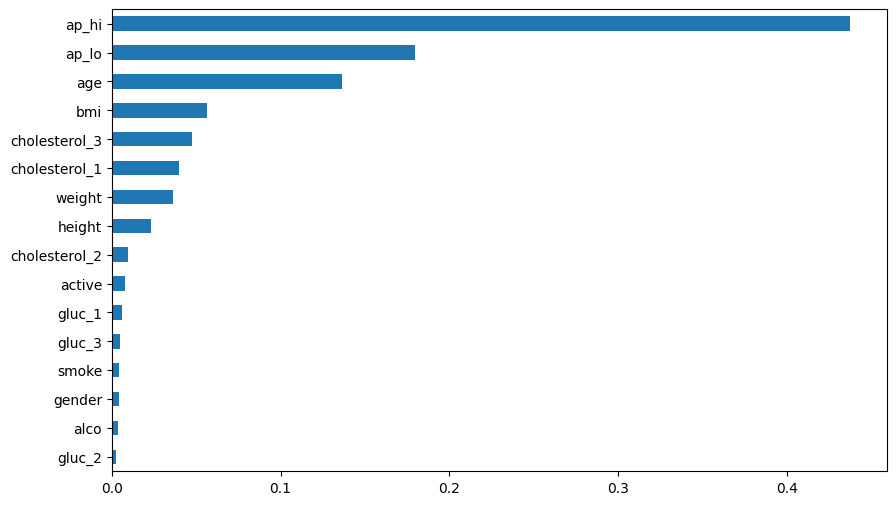

In [317]:
cardio = cardio_df.drop(columns=['cardio']).copy()
#Plot the feature importances
feat_importances = pd.Series(best_ran_tree.feature_importances_, index=cardio.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))
plt.show()

Therefore, we can observe that the top features that contribute to the positive predictions are:
* A high Systolic blood pressure and diastolic blood pressure
* Age 
* Body Mass Index (weight / height^2)
* A very high cholesterol

To make our model better, we can try to look at the different y thresholds and look at the precision and recall score. Our goal is to have a balance between precision and recall score.

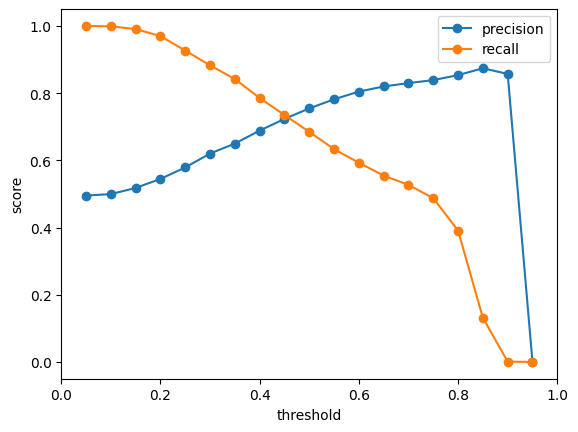

In [231]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#Get predictions
y_pred_rf = best_ran_tree.predict(X_test)
# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

precisions = []
recalls = []

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba_test_rf > threshold, 1, 0)

    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)

    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

We can observe that around 0.42-0.48, the Recall and Precision score are more in balance. Let's look at the y_threshold and Precision/Recall values :

In [239]:
# Define the range of threshold values
threshold_values = np.arange(0.42, 0.48, 0.01)
#Prin the scores for every threshold value
for threshold in threshold_values:
    # Calculate predictions based on the threshold for test and train sets
    y_threshold_test = np.where(y_proba_test_rf > threshold, 1, 0)
    y_threshold_train = np.where(y_proba_train_rf > threshold, 1, 0)
    print(f"Threshold of {threshold}:")
    # Print precision and recall scores 
    precision = precision_score(y_test, y_threshold_test)
    recall = recall_score(y_test, y_threshold_test)
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    # Print train and test scores
    train_score = np.mean(y_threshold_train == y_train)
    test_score = np.mean(y_threshold_test == y_test)
    print(f"Train score: {train_score}")
    print(f"Test score: {test_score}")
    print('#####################################') 

Threshold of 0.42:
Precision score: 0.705091649694501
Recall score: 0.7614369501466276
Train score: 0.7480679220637858
Test score: 0.7243306001015891
#####################################
Threshold of 0.43:
Precision score: 0.7120055517002082
Recall score: 0.7521994134897361
Train score: 0.7496643808279816
Test score: 0.7267977650388215
#####################################
Threshold of 0.44:
Precision score: 0.71875
Recall score: 0.7453079178885631
Train score: 0.7509524327854578
Test score: 0.7296277483491764
#####################################
Threshold of 0.45:
Precision score: 0.7232323232323232
Recall score: 0.7348973607038123
Train score: 0.7518957947824825
Test score: 0.7296277483491764
#####################################
Threshold of 0.46:
Precision score: 0.7289829512051734
Recall score: 0.7272727272727273
Train score: 0.7531475635862269
Test score: 0.731224149190915
#####################################
Threshold of 0.47000000000000003:
Precision score: 0.736415490843590

Therefore, the best y threshold is 0.44. We can see that the Precision score is 0.72 and **Recall** score is **0.74**, that is the highest recall that we could get. Also the train score is 0.75 and test score is 0.73. 

Let's look at the confusion matrix with the new threshold of 0.44: 

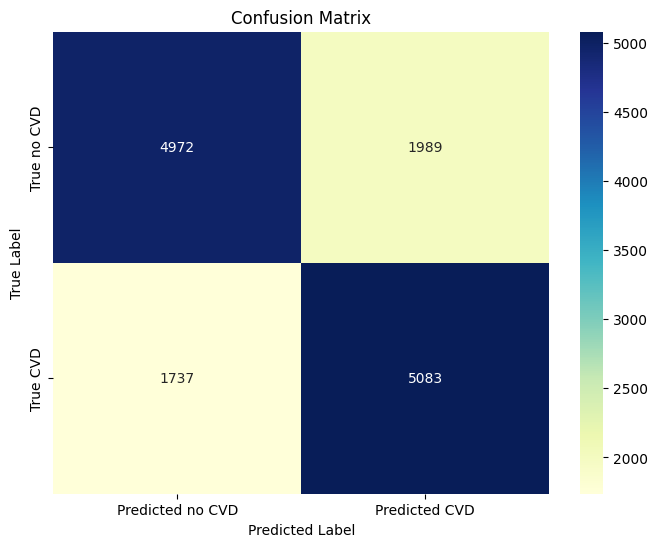

In [241]:
from sklearn.metrics import confusion_matrix

y_threshold_test = np.where(y_proba_test_rf > 0.44, 1, 0)
y_threshold_train = np.where(y_proba_train_rf > 0.44, 1, 0)

# Generate confusion matrix for test set
cm = confusion_matrix(y_test, y_threshold_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['Predicted no CVD', 'Predicted CVD'], 
            yticklabels=['True no CVD', 'True CVD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Therefore, we can observe that the number of False Negative predictions is lower (from 2150 to 1737). But also the number of False Positive has risen (from 1519 to 1989).

#### **<a id='preparation'> 5. Preparation for Streamlit app </a>**

We choosed the best model, evaluated and optimized it. Now, how we can make recommendations based on the model's predictions. 

In order to do that we need to look at how each feature contributes to the model's ouput for a specific prediction (X_new). We can do that using Shapley Values and `shap.TreeExplainer`- to compute Shapley values for the Random Forest model

In [320]:
# User data, transformed into a dataframe
X_new = [43531, 0, 157, 123.0, 140, 90, 0, 1, 1, 49.620288, 0, 0, 1, 1, 0, 0]
column_names = ['age', 'gender', 'height', 'weight', 'ap_hi',
                'ap_lo', 'smoke', 'alco', 'active', 'bmi',
                'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 
                'gluc_1', 'gluc_2', 'gluc_3']
X_new = pd.DataFrame([X_new], columns=column_names)
# calculate the probability and the prediction
y_probabilities = best_ran_tree.predict_proba(X_new)[:, 1]
threshold = 0.44
y_pred_new = (y_probabilities >= threshold).astype(int)
print("Probability of X_new to be positive:")
print(y_probabilities)
print("Predictions for X_new:")
print(y_pred_new)

Probability of X_new to be positive:
[0.72222581]
Predictions for X_new:
[1]


In [321]:
import shap
#compute shapley values for best_ran_tree model
explainer = shap.TreeExplainer(best_ran_tree)
shap_values = explainer.shap_values(X_new)
# Extract SHAP values for positive output
shap_values_pos = shap_values[0][:, 1]  
# Create DataFrames for SHAP values of positive output
shap_values_df = pd.DataFrame(shap_values_pos.reshape(1, -1), columns=column_names)
# Sort the dataframe
sorted_df = shap_values_df.sort_values(by=shap_values_df.index[0], axis=1, ascending=False)
sorted_df

,ap_hi,ap_lo,cholesterol_1,cholesterol_3,bmi,gluc_3,weight,gender,gluc_2,smoke,active,height,gluc_1,age,cholesterol_2,alco
0,0.121896,0.041181,0.036611,0.036222,0.006379,0.003164,0.002591,0.001762,0.000474,0.000158,-0.000336,-0.00131,-0.001739,-0.002113,-0.003343,-0.014365


Therefore, we can see that we got the importance of each feature that has on the positive prediction. Based on that, we can make reccomendations. For example, the risks factor of this patient that contributed to the positive prediction of CVD are:
* high blood pressure (0,121)
* a very high cholesterol level (0.036)
* body mass index (0.006)

Therefore, the patient should go to a cardiologist to manage his high blood pressure and high cholesterol level. His weight and BMI are indicating that the patient is obese, so that factor contribute negatively to his health. 

This is a example of how the **CardioLife app** will predict and make reccomendations based on the feature importance of each variable. 

To see how I developed the app, go to the folder **-> app -> CardioLife_app.py**. 

To run this map you should:
* Run on your command line: `pip install streamlit`
* Validate the installation by running the Hello app: `streamlit hello`
* on another command line window, or after closing the previous one, run: 

`streamlit run <path>/CardioLife_app.py`


### Save the model 

We need to save the model, to use it in our streamlit app. We can save it using pickle:

In [60]:
import pickle

with open('final_rf_model.pkl', 'wb') as file:
    pickle.dump(best_ran_tree, file)

#### **<a id='Conclusion'> 6. Conclusion </a>**

In this Sprint, that is also the last one, we could:
* find the best model to be **Random Forest Classifier**
* evaluated and optimized the model, setting a threshold of 0.44 for the positive predictions
* obtained the minimum of False negatives and the maximum Recall
* Developed the user friendly web app using Streamlit and the model that we saved

Next stepts that we could do in the future is:
* to do more recommendations and insert links where the users can click, to inform themselves more on the risks they have
* to improve the web app's design
* to deploy the app and share it 